In [1]:
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

# Preprocessing Data

In [2]:
data_root = '../data/'
seed = 27

df = TabularDataset(data_root + 'train_dataset.csv')
df = df.reset_index(drop=True)
# psuedo = TabularDataset(data_root + 'public_dataset_without_gt_latlon.csv')
# psuedo = pd.read_csv(data_root + 'public_dataset_without_gt_latlon.csv')
# psuedo_y = TabularDataset('top1.csv')
# psuedo = pd.concat([psuedo, psuedo_y], axis = 1)
df

,ID,pms_i_ymd,Area,Province,Shop Name,gender,date_of_birth_week,date_of_birth,marital_status,number_of_children,...,Mortgage_balance,Credit Card_balance,Automobile installment purchase_balance,Other installment purchase_balance,Loan for agriculture_balance,Other Loans_balance,Bank inquiry_count,Consumer finance inquiry_count,Leasing enquiry_count,default_12month
0,202412000001,2018/4/2,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,6,1971/5/18,1,2,...,0.0,0.0,0.0,0.0,30000.0,0.0,12,6,0,0
1,202412000002,2018/4/2,Bangkok Metropolitan Region,Bangkok,Silom Complex,M,4,1983/1/5,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2,202412000003,2018/4/3,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,5,1992/11/19,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,2,1,0,0
3,202412000004,2018/4/4,Bangkok Metropolitan Region,Bangkok,Silom Complex,M,7,1990/11/3,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
4,202412000005,2018/4/4,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,6,1994/12/16,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32519,202412049586,2018/8/31,webpak,webpak,webpak,F2,3,1995/10/24,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
32520,202412049587,2018/8/31,webpak,webpak,webpak,F2,3,1979/3/30,1,0,...,0.0,0.0,267504.0,0.0,0.0,0.0,0,0,0,0
32521,202412049588,2018/8/31,webpak,webpak,webpak,M,2,1992/5/11,1,0,...,0.0,0.0,0.0,65780.0,0.0,0.0,0,1,0,0
32522,202412049589,2018/8/31,webpak,webpak,webpak,M,2,1989/6/12,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,2,1,0


In [3]:
# print(df.iloc[:2].to_json(orient='records'))

## Train data

### Eda

In [4]:
# check data type and missing values
df.info()
# df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32524 entries, 0 to 32523
Data columns (total 61 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   ID                                       32524 non-null  int64  
 1   pms_i_ymd                                32524 non-null  object 
 2   Area                                     32524 non-null  object 
 3   Province                                 32524 non-null  object 
 4   Shop Name                                32524 non-null  object 
 5   gender                                   32524 non-null  object 
 6   date_of_birth_week                       32524 non-null  int64  
 7   date_of_birth                            32524 non-null  object 
 8   marital_status                           32524 non-null  int64  
 9   number_of_children                       32524 non-null  int64  
 10  postal_code                              32524

In [5]:
df.isna().sum()

ID                                    0
pms_i_ymd                             0
Area                                  0
Province                              0
Shop Name                             0
                                  ...  
Other Loans_balance               12945
Bank inquiry_count                    0
Consumer finance inquiry_count        0
Leasing enquiry_count                 0
default_12month                       0
Length: 61, dtype: int64

In [6]:
def print_high_null_columns(df, threshold=0.01):
    """
    Print columns that have null values exceeding the specified threshold
    
    Parameters:
    df (pandas.DataFrame): Input dataframe to analyze
    threshold (float): Threshold for null percentage (default 0.3 or 30%)
    
    Returns:
    list: List of column names exceeding the null threshold
    """
    # Calculate percentage of null values for each column
    null_percentages = df.isnull().sum() / len(df)
    
    # Filter columns where null percentage exceeds threshold
    high_null_cols = null_percentages[null_percentages > threshold]
    
    # Print results
    print("\nColumns with more than {:.1%} null values:".format(threshold))
    print("-" * 50)
    for col, pct in high_null_cols.items():
        print(f"{col:<30} {pct:.2%} null values")
    
    # Return list of column names for potential dropping
    return list(high_null_cols.index)

print_high_null_columns(df)


Columns with more than 1.0% null values:
--------------------------------------------------
r_propose                      1.50% null values
r_additional_income            10.12% null values
r_spouse_income                8.51% null values
r_generalcode1                 59.33% null values
r_generalcode2                 59.73% null values
r_generalcode3                 3.21% null values
r_generalcode4                 4.37% null values
r_generalcode5                 3.47% null values
Overdraft_count                39.80% null values
Personal Loan_count            39.80% null values
Mortgage_count                 39.80% null values
Credit Card_count              39.80% null values
Automobile installment purchase_count 39.80% null values
Other installment purchase_count 39.80% null values
Loan for agriculture_count     39.80% null values
Other Loans_count              39.80% null values
Overdraft_balance              39.80% null values
Personal Loan_balance          39.80% null values
Mor

['r_propose',
 'r_additional_income',
 'r_spouse_income',
 'r_generalcode1',
 'r_generalcode2',
 'r_generalcode3',
 'r_generalcode4',
 'r_generalcode5',
 'Overdraft_count',
 'Personal Loan_count',
 'Mortgage_count',
 'Credit Card_count',
 'Automobile installment purchase_count',
 'Other installment purchase_count',
 'Loan for agriculture_count',
 'Other Loans_count',
 'Overdraft_balance',
 'Personal Loan_balance',
 'Mortgage_balance',
 'Credit Card_balance',
 'Automobile installment purchase_balance',
 'Other installment purchase_balance',
 'Loan for agriculture_balance',
 'Other Loans_balance']

### Process

In [7]:
def drop_columns(df):
    """Drop unnecessary columns"""
    drop_columns = [
        "r_generalcode1",
        "r_generalcode2",
        "r_generalcode4",
        "r_generalcode5",
        "Overdraft_count",
        "Personal Loan_count",
        "Mortgage_count",
        "Credit Card_count",
        "Automobile installment purchase_count",
        "Other installment purchase_count",
        "Loan for agriculture_count",
        "Other Loans_count",
        "Overdraft_balance",
        "Personal Loan_balance",
        "Mortgage_balance",
        "Credit Card_balance",
        "Automobile installment purchase_balance",
        "Other installment purchase_balance",
        "Loan for agriculture_balance",
        "Other Loans_balance",
    ]

    # drop_columns = [
    #     "r_generalcode1",
    #     "r_generalcode2",
    #     "r_generalcode4",
    #     "r_generalcode5",
    #     "Overdraft_count",
    #     "Personal Loan_count",
    #     "Mortgage_count",
    #     "Credit Card_count",
    #     "Automobile installment purchase_count",
    #     "Other installment purchase_count",
    #     "Loan for agriculture_count",
    #     "Other Loans_count",
    #     "Overdraft_balance",
    #     "Personal Loan_balance",
    #     "Mortgage_balance",
    #     "Credit Card_balance",
    #     "Automobile installment purchase_balance",
    #     "Other installment purchase_balance",
    #     "Loan for agriculture_balance",
    #     "Other Loans_balance",
    # ]
    return df.drop(columns=drop_columns)


def handle_missing_values(df):
    """Handle missing values with appropriate strategies"""
    df = df.copy()

    # Simple zero imputation for income
    df["r_additional_income"] = df["r_additional_income"].fillna(0)
    df["r_spouse_income"] = df["r_spouse_income"].fillna(0)

    # Business type specific imputation for credit limit
    df["r_expected_credit_limit"] = df.groupby("c_business_type")[
        "r_expected_credit_limit"
    ].transform(lambda x: x.fillna(x.median()))

    # Mode imputation for categorical
    df["r_generalcode3"] = df["r_generalcode3"].fillna(4)
    df["r_propose"] = df["r_propose"].fillna(6) # less than 1.5% missing fill other category
    df["c_date_of_salary_payment"] = df["c_date_of_salary_payment"].fillna(1) # less than 1% missing

    return df


def calculate_age(df):
    """Calculate age from date of birth"""
    df = df.copy()
    df["date_of_birth"] = pd.to_datetime(df["date_of_birth"])
    reference_date = pd.to_datetime("2024-01-01")
    df["age"] = (reference_date - df["date_of_birth"]).dt.days // 365

    df["pms_i_ymd"] = pd.to_datetime(df["pms_i_ymd"])
    # Create age at application
    df["age_application"] = (df["pms_i_ymd"] - df["date_of_birth"]).dt.days // 365

    return df.drop(["date_of_birth", "pms_i_ymd"], axis=1)


def calculate_income_features(df):
    """Calculate income-related features"""
    df = df.copy()

    # Basic income calculations
    df["total_income"] = (
        df["c_monthly_salary"] + df["r_additional_income"] + df["r_spouse_income"]
    )

    # Income ratios
    df["income_per_dependent"] = df["total_income"] / (df["number_of_children"] + 1)
    df["income_per_resident"] = df["total_income"] / df["number_of_resident"]
    df["multiple_income_sources"] = (
        (df["r_additional_income"] > 0) | (df["r_spouse_income"] > 0)
    ).astype(int)

    # Drop original columns
    df = df.drop(columns=["c_monthly_salary", "r_additional_income", "r_spouse_income"])

    return df


def calculate_stability_features(df):
    """Calculate stability-related features"""
    df = df.copy()

    # Employment stability
    df["employment_months"] = (
        df["c_number_of_working_year"] * 12 + df["c_number_of_working_month"]
    )
    df["job_stability_score"] = df["employment_months"] / df["age"]

    # Living stability
    df["living_months"] = df["living_period_year"] * 12 + df["living_period_month"]
    df["residence_stability_score"] = df["living_months"] / df["age"]

    # Drop original columns
    df = df.drop(
        columns=[
            "c_number_of_working_year",
            "c_number_of_working_month",
            "living_period_year",
            "living_period_month",
        ]
    )

    return df


def calculate_risk_features(df):
    """Calculate risk-related features"""
    df = df.copy()

    # Credit inquiries
    df["total_inquiries"] = (
        df["Bank inquiry_count"] + df["Consumer finance inquiry_count"]
    )
    df["high_inquiry_flag"] = (df["total_inquiries"] > 3).astype(int)

    # Debt metrics
    df["debt_burden"] = df["r_allloan_amount"] / (df["total_income"] * 12)
    df["credit_limit_ratio"] = df["r_expected_credit_limit"] / df["total_income"]

    # Business risk
    business_risk_map = {
        16: 1,
        14: 1,  # Low risk (government, education)
        15: 2,
        11: 2,
        12: 2,  # Medium-low risk (hospital, finance, insurance)
        4: 3,
        7: 3,  # Medium risk (manufacturing, business service)
        8: 4,
        5: 4,  # High risk (individual service, merchant)
    }
    df["business_risk_level"] = df["c_business_type"].map(business_risk_map).fillna(3)

    # Composite risk score
    df["high_risk_flags"] = (
        (df["living_months"] < 12).astype(int)
        + (df["employment_months"] < 12).astype(int)
        + (df["debt_burden"] > 0.5).astype(int)
        + (df["high_inquiry_flag"])
    )

    return df


def encode_categorical_features(df):
    """Encode categorical features"""
    categorical_cols = ["gender", "Area", "Province", "Shop Name", "apply"]
    return pd.get_dummies(df, columns=categorical_cols)


def preprocess(df):
    """Main preprocessing pipeline"""
    df = df.copy()

    # Basic preprocessing
    df = drop_columns(df)
    df = handle_missing_values(df)

    # Feature engineering
    df = calculate_age(df)
    df = calculate_income_features(df)
    df = calculate_stability_features(df)
    df = calculate_risk_features(df)

    # Encoding and scaling
    # df = encode_categorical_features(df)

    return df


In [8]:
data = preprocess(df)
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()
data["y"] = data["default_12month"].astype("int")

data = data.drop(columns=["default_12month"])
data = data.reset_index(drop=True)
data

,ID,Area,Province,Shop Name,gender,date_of_birth_week,marital_status,number_of_children,postal_code,tel_category,...,job_stability_score,living_months,residence_stability_score,total_inquiries,high_inquiry_flag,debt_burden,credit_limit_ratio,business_risk_level,high_risk_flags,y
0,202412000001,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,6,1,2,10400,3,...,1.153846,60,1.153846,18,1,0.000000,4.410143,3.0,1,0
1,202412000002,Bangkok Metropolitan Region,Bangkok,Silom Complex,M,4,1,0,10500,3,...,1.560976,48,1.170732,0,0,0.000000,1.192962,3.0,0,0
2,202412000003,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,5,1,0,10170,3,...,0.096774,62,2.000000,3,0,0.079974,1.919386,3.0,1,0
3,202412000004,Bangkok Metropolitan Region,Bangkok,Silom Complex,M,7,1,2,10500,3,...,1.545455,51,1.545455,0,0,0.000000,1.098177,3.0,0,0
4,202412000005,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,6,3,1,10120,3,...,0.068966,4,0.137931,0,0,0.000000,1.344086,3.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32509,202412049586,webpak,webpak,webpak,F2,3,1,0,12120,3,...,0.321429,12,0.428571,0,0,0.000000,4.981685,3.0,1,0
32510,202412049587,webpak,webpak,webpak,F2,3,1,0,25140,3,...,0.545455,180,4.090909,0,0,0.000000,4.882115,3.0,0,0
32511,202412049588,webpak,webpak,webpak,M,2,1,0,20230,3,...,0.258065,24,0.774194,1,0,0.000000,2.192982,3.0,1,0
32512,202412049589,webpak,webpak,webpak,M,2,1,0,20150,3,...,0.205882,30,0.882353,2,0,0.000000,4.943733,3.0,1,0


In [9]:
pd.set_option('display.max_columns', None)
data

,ID,Area,Province,Shop Name,gender,date_of_birth_week,marital_status,number_of_children,postal_code,tel_category,number_of_resident,type_of_residence,c_postal_code,c_business_type,c_number_of_employee,c_position,c_occupation,c_employment_status,c_salary_payment_methods,c_date_of_salary_payment,media,place_for_sending_information,r_expected_credit_limit,r_propose,r_allloan_case,r_allloan_amount,r_generalcode3,apply,Bank inquiry_count,Consumer finance inquiry_count,Leasing enquiry_count,age,age_application,total_income,income_per_dependent,income_per_resident,multiple_income_sources,employment_months,job_stability_score,living_months,residence_stability_score,total_inquiries,high_inquiry_flag,debt_burden,credit_limit_ratio,business_risk_level,high_risk_flags,y
0,202412000001,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,6,1,2,10400,3,2,6,10330.0,7,9999,5,55,5,1,30.0,7,1,40000.0,5.0,0.0,0,2.0,WI,12,6,0,52,46,9070.0,3023.333333,4535.000000,0,60,1.153846,60,1.153846,18,1,0.000000,4.410143,3.0,1,0
1,202412000002,Bangkok Metropolitan Region,Bangkok,Silom Complex,M,4,1,0,10500,3,3,6,10500.0,7,500,5,55,5,1,28.0,8,2,20000.0,6.0,0.0,0,1.0,WI,0,0,0,41,35,16765.0,16765.000000,5588.333333,1,64,1.560976,48,1.170732,0,0,0.000000,1.192962,3.0,0,0
2,202412000003,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,5,1,0,10170,3,6,3,10310.0,7,1000,4,53,5,1,30.0,7,1,20000.0,5.0,1.0,10000,1.0,DS,2,1,0,31,25,10420.0,10420.000000,1736.666667,0,3,0.096774,62,2.000000,3,0,0.079974,1.919386,3.0,1,0
3,202412000004,Bangkok Metropolitan Region,Bangkok,Silom Complex,M,7,1,2,10500,3,2,5,10500.0,3,500,5,55,2,1,31.0,1,2,15000.0,5.0,0.0,0,1.0,WI,0,0,0,33,27,13659.0,4553.000000,6829.500000,0,51,1.545455,51,1.545455,0,0,0.000000,1.098177,3.0,0,0
4,202412000005,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,6,3,1,10120,3,2,4,10120.0,7,1000,5,55,5,1,14.0,7,2,10000.0,5.0,0.0,0,1.0,DS,0,0,0,29,23,7440.0,3720.000000,3720.000000,0,2,0.068966,4,0.137931,0,0,0.000000,1.344086,3.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32509,202412049586,webpak,webpak,webpak,F2,3,1,0,12120,3,3,2,12120.0,7,4500,5,54,5,1,28.0,1,1,34000.0,6.0,0.0,0,4.0,OT,0,0,0,28,22,6825.0,6825.000000,2275.000000,0,9,0.321429,12,0.428571,0,0,0.000000,4.981685,3.0,1,0
32510,202412049587,webpak,webpak,webpak,F2,3,1,0,25140,3,2,3,25140.0,4,600,5,54,2,1,10.0,1,1,41000.0,5.0,0.0,0,4.0,OT,0,0,0,44,39,8398.0,8398.000000,4199.000000,0,24,0.545455,180,4.090909,0,0,0.000000,4.882115,3.0,0,0
32511,202412049588,webpak,webpak,webpak,M,2,1,0,20230,3,2,6,20110.0,4,3000,5,54,1,1,5.0,1,1,20000.0,6.0,0.0,0,4.0,OT,0,1,0,31,26,9120.0,9120.000000,4560.000000,0,8,0.258065,24,0.774194,1,0,0.000000,2.192982,3.0,1,0
32512,202412049589,webpak,webpak,webpak,M,2,1,0,20150,3,2,2,21140.0,4,500,5,54,1,1,5.0,1,2,76000.0,5.0,0.0,0,4.0,OT,0,2,1,34,29,15373.0,15373.000000,7686.500000,0,7,0.205882,30,0.882353,2,0,0.000000,4.943733,3.0,1,0


In [10]:
test_size = int(0.2 * len(data))

test_data = data.sample(test_size, random_state = seed)
train_data = data.drop(test_data.index)
train_data = train_data.reset_index(drop=True)
train_data

,ID,Area,Province,Shop Name,gender,date_of_birth_week,marital_status,number_of_children,postal_code,tel_category,number_of_resident,type_of_residence,c_postal_code,c_business_type,c_number_of_employee,c_position,c_occupation,c_employment_status,c_salary_payment_methods,c_date_of_salary_payment,media,place_for_sending_information,r_expected_credit_limit,r_propose,r_allloan_case,r_allloan_amount,r_generalcode3,apply,Bank inquiry_count,Consumer finance inquiry_count,Leasing enquiry_count,age,age_application,total_income,income_per_dependent,income_per_resident,multiple_income_sources,employment_months,job_stability_score,living_months,residence_stability_score,total_inquiries,high_inquiry_flag,debt_burden,credit_limit_ratio,business_risk_level,high_risk_flags,y
0,202412000001,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,6,1,2,10400,3,2,6,10330.0,7,9999,5,55,5,1,30.0,7,1,40000.0,5.0,0.0,0,2.0,WI,12,6,0,52,46,9070.0,3023.333333,4535.000000,0,60,1.153846,60,1.153846,18,1,0.000000,4.410143,3.0,1,0
1,202412000003,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,5,1,0,10170,3,6,3,10310.0,7,1000,4,53,5,1,30.0,7,1,20000.0,5.0,1.0,10000,1.0,DS,2,1,0,31,25,10420.0,10420.000000,1736.666667,0,3,0.096774,62,2.000000,3,0,0.079974,1.919386,3.0,1,0
2,202412000004,Bangkok Metropolitan Region,Bangkok,Silom Complex,M,7,1,2,10500,3,2,5,10500.0,3,500,5,55,2,1,31.0,1,2,15000.0,5.0,0.0,0,1.0,WI,0,0,0,33,27,13659.0,4553.000000,6829.500000,0,51,1.545455,51,1.545455,0,0,0.000000,1.098177,3.0,0,0
3,202412000005,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,6,3,1,10120,3,2,4,10120.0,7,1000,5,55,5,1,14.0,7,2,10000.0,5.0,0.0,0,1.0,DS,0,0,0,29,23,7440.0,3720.000000,3720.000000,0,2,0.068966,4,0.137931,0,0,0.000000,1.344086,3.0,2,1
4,202412000006,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,3,1,0,10400,3,2,6,10500.0,8,436,4,53,1,2,30.0,7,1,5000.0,5.0,0.0,0,2.0,WI,0,0,0,30,24,9360.0,9360.000000,4680.000000,0,36,1.200000,24,0.800000,0,0,0.000000,0.534188,4.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26007,202412049586,webpak,webpak,webpak,F2,3,1,0,12120,3,3,2,12120.0,7,4500,5,54,5,1,28.0,1,1,34000.0,6.0,0.0,0,4.0,OT,0,0,0,28,22,6825.0,6825.000000,2275.000000,0,9,0.321429,12,0.428571,0,0,0.000000,4.981685,3.0,1,0
26008,202412049587,webpak,webpak,webpak,F2,3,1,0,25140,3,2,3,25140.0,4,600,5,54,2,1,10.0,1,1,41000.0,5.0,0.0,0,4.0,OT,0,0,0,44,39,8398.0,8398.000000,4199.000000,0,24,0.545455,180,4.090909,0,0,0.000000,4.882115,3.0,0,0
26009,202412049588,webpak,webpak,webpak,M,2,1,0,20230,3,2,6,20110.0,4,3000,5,54,1,1,5.0,1,1,20000.0,6.0,0.0,0,4.0,OT,0,1,0,31,26,9120.0,9120.000000,4560.000000,0,8,0.258065,24,0.774194,1,0,0.000000,2.192982,3.0,1,0
26010,202412049589,webpak,webpak,webpak,M,2,1,0,20150,3,2,2,21140.0,4,500,5,54,1,1,5.0,1,2,76000.0,5.0,0.0,0,4.0,OT,0,2,1,34,29,15373.0,15373.000000,7686.500000,0,7,0.205882,30,0.882353,2,0,0.000000,4.943733,3.0,1,0


In [11]:
data['y'].value_counts(normalize=True)

y
0    0.870487
1    0.129513
Name: proportion, dtype: float64

# Submission data

you need to use same data as train data for predict

In [12]:
test = TabularDataset(data_root + 'public_dataset_without_gt.csv')
test = preprocess(test)
test

,ID,Area,Province,Shop Name,gender,date_of_birth_week,marital_status,number_of_children,postal_code,tel_category,number_of_resident,type_of_residence,c_postal_code,c_business_type,c_number_of_employee,c_position,c_occupation,c_employment_status,c_salary_payment_methods,c_date_of_salary_payment,media,place_for_sending_information,r_expected_credit_limit,r_propose,r_allloan_case,r_allloan_amount,r_generalcode3,apply,Bank inquiry_count,Consumer finance inquiry_count,Leasing enquiry_count,age,age_application,total_income,income_per_dependent,income_per_resident,multiple_income_sources,employment_months,job_stability_score,living_months,residence_stability_score,total_inquiries,high_inquiry_flag,debt_burden,credit_limit_ratio,business_risk_level,high_risk_flags
0,202412000196,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,2,2,2,10120,3,4,6,10500.0,7,20,5,55,5,1,31.0,3,2,5000.0,5.0,0.0,0,1.0,WI,1,3,0,42,37,24150.0,8050.00,6037.5,1,1,0.023810,108,2.571429,4,1,0.000000,0.207039,3.0,2
1,202412000241,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,2,2,0,10120,3,5,6,10120.0,4,60,5,54,1,1,1.0,7,1,10000.0,5.0,3.0,20000,2.0,WI,0,12,0,30,25,24700.0,24700.00,4940.0,1,23,0.766667,38,1.266667,12,1,0.067476,0.404858,3.0,1
2,202412000242,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,4,1,0,10120,3,1,6,10120.0,4,300,5,54,2,1,25.0,7,1,20000.0,5.0,2.0,17000,2.0,WI,1,4,0,47,42,8800.0,8800.00,8800.0,1,3,0.063830,24,0.510638,5,1,0.160985,2.272727,3.0,2
3,202412000243,Bangkok Metropolitan Region,Bangkok,Silom Complex,F1,5,3,3,10530,3,6,3,10500.0,5,5000,2,20,1,1,31.0,7,2,50000.0,5.0,3.0,50000,2.0,WI,12,2,1,44,38,25215.0,6303.75,4202.5,0,76,1.727273,120,2.727273,14,1,0.165246,1.982947,4.0,1
4,202412000244,Bangkok Metropolitan Region,Bangkok,Silom Complex,M,2,2,2,10700,3,5,6,10120.0,5,3400,4,51,1,1,30.0,3,1,10000.0,5.0,0.0,0,1.0,WI,0,0,0,35,29,36660.0,12220.00,7332.0,1,16,0.457143,16,0.457143,0,0,0.000000,0.272777,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6562,202412049778,webpak,webpak,webpak,F2,7,2,1,20230,3,2,6,20230.0,4,28,5,54,1,1,25.0,1,1,54000.0,6.0,0.0,0,4.0,OT,0,3,0,38,33,10900.0,5450.00,5450.0,0,12,0.315789,27,0.710526,3,0,0.000000,4.954128,3.0,0
6563,202412049779,webpak,webpak,webpak,F2,1,1,0,20230,3,1,6,21140.0,4,3000,5,54,1,1,25.0,1,2,0.0,6.0,0.0,0,4.0,OT,0,7,0,30,24,10300.0,10300.00,10300.0,0,21,0.700000,26,0.866667,7,1,0.000000,0.000000,3.0,1
6564,202412049780,webpak,webpak,webpak,M,5,2,0,21140,3,4,2,20230.0,7,1000,5,55,5,1,3.0,1,1,34000.0,6.0,0.0,0,4.0,OT,0,0,0,54,49,6930.0,6930.00,1732.5,0,24,0.444444,62,1.148148,0,0,0.000000,4.906205,3.0,0
6565,202412049781,webpak,webpak,webpak,F2,3,1,0,20000,3,1,6,20000.0,4,1000,5,54,1,1,27.0,1,2,14000.0,5.0,0.0,0,4.0,OT,2,3,0,36,30,14228.0,14228.00,14228.0,0,60,1.666667,67,1.861111,5,1,0.000000,0.983975,3.0,1


In [13]:
test.describe()

/root/miniforge3/envs/ag/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,ID,date_of_birth_week,marital_status,number_of_children,postal_code,tel_category,number_of_resident,type_of_residence,c_postal_code,c_business_type,c_number_of_employee,c_position,c_occupation,c_employment_status,c_salary_payment_methods,c_date_of_salary_payment,media,place_for_sending_information,r_expected_credit_limit,r_propose,r_allloan_case,r_allloan_amount,r_generalcode3,Bank inquiry_count,Consumer finance inquiry_count,age,age_application,total_income,income_per_dependent,income_per_resident,multiple_income_sources,employment_months,job_stability_score,living_months,residence_stability_score,total_inquiries,high_inquiry_flag,debt_burden,credit_limit_ratio,business_risk_level,high_risk_flags
count,6.567000e+03,6567.000000,6567.000000,6567.000000,6567.000000,6567.000000,6567.000000,6567.000000,6566.000000,6567.000000,6567.000000,6567.000000,6567.000000,6567.000000,6567.000000,6567.000000,6567.000000,6567.000000,6.567000e+03,6567.000000,6567.000000,6567.000000,6567.000000,6567.000000,6567.000000,6567.000000,6567.000000,6567.000000,6567.000000,6567.0,6567.000000,6567.000000,6567.000000,6567.000000,6567.000000,6567.000000,6567.000000,6567.000000,6567.000000,6567.000000,6567.000000
mean,2.024120e+11,3.985381,2.221106,0.919598,29039.537232,2.970611,3.308817,3.795645,28847.619555,5.728034,931.255215,4.531445,50.845135,1.986600,1.052688,22.825187,4.723770,1.471448,2.210152e+04,4.501294,12.034414,13868.617329,1.476016,1.965586,3.550327,38.554439,33.250952,20641.894625,12731.159226,inf,0.506015,46.853510,1.126493,126.307599,3.307802,5.515913,0.431704,0.060399,1.326136,3.112989,0.821380
std,1.456060e+04,1.984888,1.578727,0.995233,24009.093598,0.238449,2.004249,2.036589,23922.164561,2.788304,1793.677229,0.668154,6.442410,1.443041,0.225462,10.272878,3.050068,0.499222,3.134457e+04,1.383387,507.040875,28056.439812,0.720228,4.883508,5.146604,8.768247,8.762411,15635.906542,10614.411302,NaN,0.500002,58.424327,1.237268,139.403068,3.613134,8.044974,0.495351,0.114628,1.358690,0.621496,0.694774
min,2.024120e+11,1.000000,1.000000,0.000000,121.000000,1.000000,0.000000,1.000000,10100.000000,1.000000,1.000000,2.000000,20.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000e+00,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,25.000000,20.000000,5010.000000,957.500000,487.5,0.000000,1.000000,0.017544,1.000000,0.019608,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.024120e+11,2.000000,1.000000,0.000000,10540.000000,3.000000,2.000000,2.000000,10540.000000,4.000000,100.000000,4.000000,51.000000,1.000000,1.000000,20.000000,1.000000,1.000000,1.000000e+04,5.000000,0.000000,0.000000,1.000000,0.000000,0.000000,31.000000,26.000000,10580.000000,7119.750000,3639.0,0.000000,9.000000,0.258065,24.000000,0.642857,1.000000,0.000000,0.000000,0.649077,3.000000,0.000000
50%,2.024120e+11,4.000000,2.000000,1.000000,20140.000000,3.000000,3.000000,3.000000,20135.000000,5.000000,300.000000,5.000000,54.000000,1.000000,1.000000,28.000000,7.000000,1.000000,2.000000e+04,5.000000,0.000000,0.000000,1.000000,0.000000,2.000000,37.000000,32.000000,16800.000000,10375.000000,6000.0,1.000000,24.000000,0.677419,60.000000,1.636364,3.000000,0.000000,0.000000,1.052484,3.000000,1.000000
75%,2.024120e+11,6.000000,3.000000,2.000000,40270.000000,3.000000,4.000000,6.000000,40000.000000,7.000000,1000.000000,5.000000,54.000000,2.000000,1.000000,30.000000,7.000000,2.000000,2.000000e+04,5.000000,1.000000,20000.000000,2.000000,2.000000,5.000000,45.000000,39.000000,26000.000000,15000.000000,10725.0,1.000000,60.000000,1.553640,192.000000,4.528302,7.000000,1.000000,0.083333,1.613294,3.000000,1.000000
max,2.024120e+11,7.000000,5.000000,6.000000,93170.000000,3.000000,35.000000,7.000000,93000.000000,16.000000,9999.000000,5.000000,55.000000,5.000000,3.000000,31.000000,12.000000,2.000000,1.000005e+06,6.000000,32000.000000,550000.000000,4.000000,80.000000,63.000000,65.000000,59.000000,409300.000000,187765.000000,inf,1.000000,432.000000,11.733333,684.000000,24.428571,104.000000,1

# Train

In [ ]:
preset = [
    "best_quality",
    "high_quality",
    "good_quality",
    "medium_quality",
    "optimize_for_deployment",
][1]

included = ["XGB", "GMB", "RF", "XT", "catboost"]
# excluded_model_types = ["KNN", "NN_TORCH", "catboost"]
# problem_type = "regression"
problem_type = "binary"


eval_metric = ["roc_auc"]  # , "f1", "average_precision"]

time_limit = 30 * 60
num_cpus = 8
num_gpus = 1
predictor = TabularPredictor(
    label="y",
    verbosity=2,
    problem_type=problem_type,
    eval_metric=eval_metric[0],
    sample_weight="balance_weight",  # "auto_weight"
    # eval_metric=eval_metric,
).fit(
    train_data=train_data,
    presets=preset,
    num_gpus=num_gpus,
    num_cpus=num_cpus,
    time_limit=time_limit,
    included_model_types=included,
    #  excluded_model_types = excluded_model_types,
    # num_bag_folds=5,
)

No path specified. Models will be saved in: "AutogluonModels/ag-20241207_085612"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.8
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Nov 5 00:21:55 UTC 2024
CPU Count:          12
Memory Avail:       19.11 GB / 23.47 GB (81.4%)
Disk Space Avail:   895.38 GB / 1006.85 GB (88.9%)
Presets specified: ['high_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Note: `save_bag_folds=False`! This will greatly reduce peak disk usage during fit (by ~8x), but runs the risk of an out-of-memory error during model refit if memory is small relative to the data size.
	You can avoid this risk by setting `save_bag_folds=True`.
DyStack is enabled (dynamic_sta

# load model

In [ ]:
model_path = 'AutogluonModels/ag-20231213_162551'
predictor = TabularPredictor.load(model_path)

# Prediction and Evaluation

In [15]:
# test on train data
top = predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val eval_metric  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   0.629812     roc_auc       0.104559  16.072336                0.002050           0.207184            2       True          5
1       CatBoost_BAG_L1   0.627629     roc_auc       0.022751  10.757471                0.022751          10.757471            1       True          3
2     LightGBMXT_BAG_L1   0.618150     roc_auc       0.043430   2.195511                0.043430           2.195511            1       True          1
3       LightGBM_BAG_L1   0.609145     roc_auc       0.038089   2.151269                0.038089           2.151269            1       True          2
4  LightGBMLarge_BAG_L1   0.605324     roc_auc       0.036329   2.912170                0.036329           2.912170            1       True          4
Number of models trained: 5
Type

/root/miniforge3/envs/ag/lib/python3.12/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


In [19]:
# test on eval
predictor.leaderboard(test_data, silent=True, extra_info=True, extra_metrics=[eval_metric])
# predictor.model_names()

/root/miniforge3/envs/ag/lib/python3.12/site-packages/autogluon/tabular/models/fastainn/tabular_nn_fastai.py:188: RuntimeWarning: invalid value encountered in subtract
  (X[self.cont_columns].values - cont_mean) / cont_std,
/root/miniforge3/envs/ag/lib/python3.12/site-packages/autogluon/tabular/models/fastainn/tabular_nn_fastai.py:188: RuntimeWarning: invalid value encountered in subtract
  (X[self.cont_columns].values - cont_mean) / cont_std,


AttributeError: 'list' object has no attribute 'name'

In [20]:
model_name = "NeuralNetFastAI_BAG_L1" # predictor.model_names()[0]

## For regression

({'root_mean_squared_error': -0.3215913731283463,
  'mean_squared_error': -0.10342101127057524,
  'mean_absolute_error': -0.21185954611011573,
  'r2': 0.03869950771331787,
  'pearsonr': 0.20044966620125854,
  'median_absolute_error': -0.1270751804113388},
 <Axes: >)

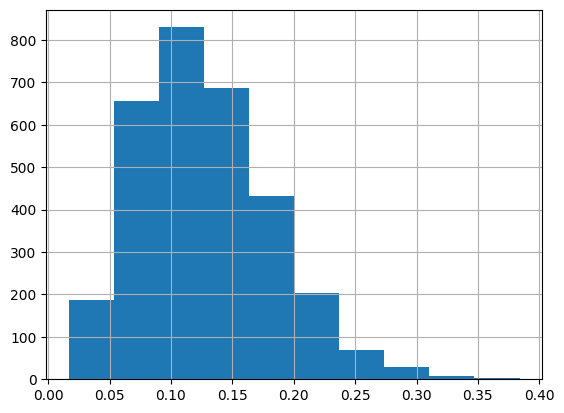

In [ ]:
pred = predictor.predict(test, model=model_name)
perf = predictor.evaluate_predictions(y_true=test_data['y'], y_pred=pred, auxiliary_metrics=True)
perf, pred.hist()

AUC Score: 0.6685681655407367


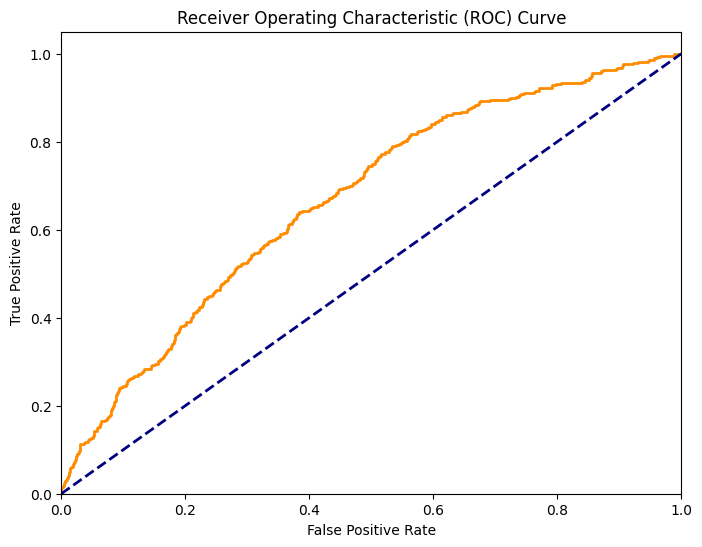

In [ ]:
auc_score = roc_auc_score(test_data['y'], pred)
print(f"AUC Score: {auc_score}")

fpr, tpr, thresholds = roc_curve(test_data['y'], pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

In [29]:
def eval_auc(test_data):
    global predictor
    model_names = predictor.model_names()

    y_test = test_data['y']
    test_data_nolab = test_data.drop(columns=['y'])
    auc_roc_scores = {}
    for model_name in model_names:
        try:
            y_pred = predictor.predict(test_data_nolab, model=model_name)
        except Exception as e:
            print(f"Model {model_name} does not support predict method : {e}")
            continue
        auc_roc = roc_auc_score(y_test, y_pred)
        auc_roc_scores[model_name] = auc_roc
    
    top = pd.DataFrame.from_dict(auc_roc_scores, orient='index', columns=['AUC-ROC'])
    top = top.sort_values(by=['AUC-ROC'], ascending=False)
    return top

In [30]:
eval_auc(test_data)

Model LightGBMXT_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'predict'
Model LightGBM_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'predict'
Model CatBoost_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'predict'
Model NeuralNetFastAI_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'dls'
Model XGBoost_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'set_params'
Model NeuralNetTorch_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'predict'
Model LightGBMLarge_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'predict'
Model CatBoost_r177_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'predict'
Model NeuralNetTorch_r79_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'predict'
Model LightGBM_r131_BAG_L1 does not support predict method

,AUC-ROC
CatBoost_BAG_L1_FULL,0.672644
CatBoost_r137_BAG_L1_FULL,0.669088
WeightedEnsemble_L2_FULL,0.668789
WeightedEnsemble_L3_FULL,0.668568
CatBoost_r9_BAG_L2_FULL,0.667053
CatBoost_BAG_L2_FULL,0.666182
CatBoost_r177_BAG_L1_FULL,0.666125
CatBoost_r177_BAG_L2_FULL,0.665734
CatBoost_r13_BAG_L1_FULL,0.663764
CatBoost_r9_BAG_L1_FULL,0.662387


## For Binary

In [23]:
y_test = predictor.predict_proba(test_data, model = model_name)
# y_test = predictor.predict_proba(test_data)
# y_test = predictor.predict_proba(test_data)
perf = predictor.evaluate_predictions(y_true=test_data['y'], y_pred=y_test, auxiliary_metrics=True)

AttributeError: 'AutoTrainer' object has no attribute 'prefvwdict_proba'

In [ ]:
auc_score = roc_auc_score(test_data['y'], y_test[1])
print(f"AUC Score: {auc_score}")

fpr, tpr, thresholds = roc_curve(test_data['y'], y_test[1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

In [ ]:
pred = predictor.predict_proba(test, model=model_name)[1]

## Feature

In [31]:
predictor.feature_importance(test_data)

Computing feature importance via permutation shuffling for 41 features using 3099 rows with 5 shuffle sets...
	255.14s	= Expected runtime (51.03s per shuffle set)


KeyboardInterrupt: 

# Submit

(<Axes: >, <Axes: >)

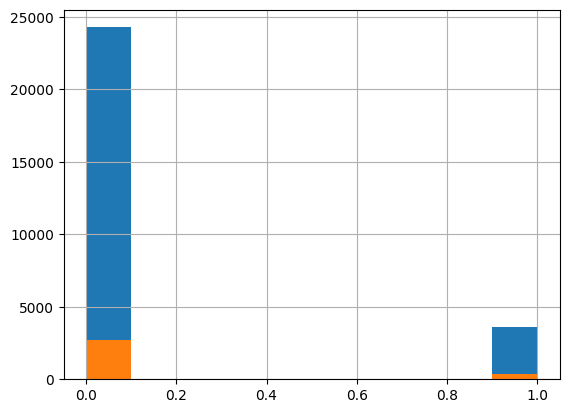

In [33]:
train_data['y'].hist(), test_data['y'].hist()

<Axes: >

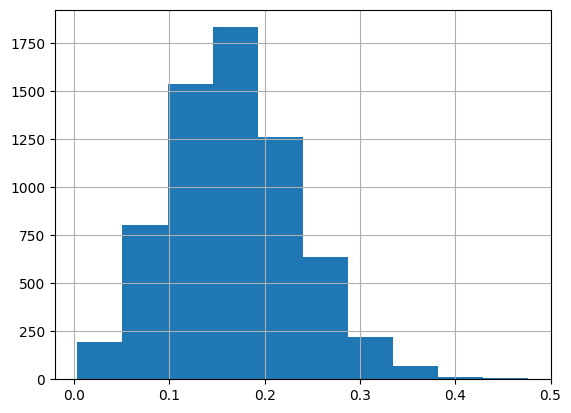

In [ ]:
pred.hist()

<Axes: >

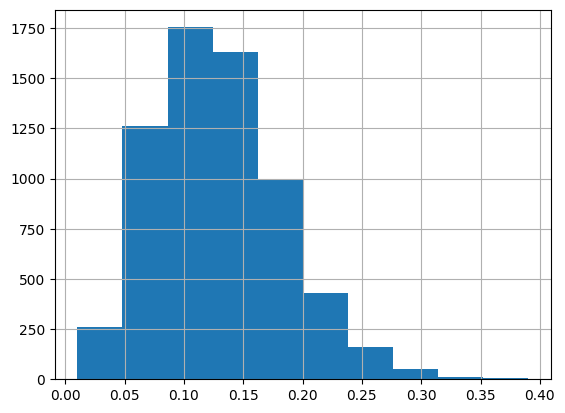

In [36]:
# pred = predictor.predict_proba(test) #, model=model_nam)
# pred = pred[1]
# model_name = "RandomForestMSE_BAG_L2_FULL"
# model_name = "ExtraTreesMSE_BAG_L1_FULL"
model_name = "CatBoost_BAG_L1_FULL"
pred = predictor.predict(test, model=model_name)
pred = predictor.predict(test)
pred.hist()

In [37]:
sub = pd.read_csv(data_root + 'submission_template_for_public.csv')
# sub = sub[['no']]
sub

,ID,default_12month
0,2.024120e+11,0
1,2.024120e+11,0
2,2.024120e+11,0
3,2.024120e+11,0
4,2.024120e+11,0
...,...,...
6562,2.024120e+11,0
6563,2.024120e+11,0
6564,2.024120e+11,0
6565,2.024120e+11,0


In [38]:
sub['default_12month'] = pred
sub

,ID,default_12month
0,2.024120e+11,0.172154
1,2.024120e+11,0.131463
2,2.024120e+11,0.133517
3,2.024120e+11,0.140639
4,2.024120e+11,0.151702
...,...,...
6562,2.024120e+11,0.047930
6563,2.024120e+11,0.053377
6564,2.024120e+11,0.090548
6565,2.024120e+11,0.058738


In [39]:
sub.to_csv(f'99_{model_name}.csv', index=False)
# sub.to_csv(".csv", index=False)

In [ ]:
eval_auc(train_data)

In [ ]:
import os

In [ ]:
model_names = predictor.model_names()

save_path = 'submission/'
os.makedirs(save_path, exist_ok=True)

for model_name in model_names:
    try:
        pred = predictor.predict(test, model=model_name)
    except:
        print(f"Model {model_name} does not support predict method")
        continue
    # Compute AUC-ROC
    
    sub['default_12month'] = pred
    sub.to_csv(f'{save_path}99_{model_name}.csv', index=False)